In [1]:
import torch
import torch.nn as nn
from os.path import isfile

from config import *
from utils import BaselineTrainer, GNNTrainer
from gnn import GNNModel
from utils import TrafficVolumeDataLoader, TrafficVolumeGraphDataLoader, create_edge_index_and_features

%run "unpack_data.py"
%run "preprocess_data.py"

First timestamp: 2014-12-31 23:00:00+00:00
Last timestamp: 2022-12-31 21:00:00+00:00
Building time series dataframe... Please grab a coffee!


100%|██████████| 109/109 [00:52<00:00,  2.06it/s]


Dropping stations with too few observations (<1500)...
Filling rows with all NaN...
Time series contain 70127 hours of data from 95 stations. (Missing observations have value NaN)
Split: 49089 (train), 10519 (val) and 10519 (test) samples
Time series data saved to "data\time_series_train.pkl", "data\time_series_val.pkl" and "data\time_series_test.pkl"
IDs of stations included in pre-processed data saved to data\stations_included.csv.


In [2]:
class BaseLineModel(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 98
        output_size = 95
        self.fcnn = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = self.fcnn(x)
        return x

Loaded datafile data\time_series_train.pkl with 49088 rows...
Loaded datafile data\time_series_val.pkl with 10518 rows...
Loaded datafile data\time_series_test.pkl with 10518 rows...
Earlystopper active with limit: 20 steps and delta: 0.5.
Training model...


Epoch 00/05 | Loss (Train): 288.8982 | Loss (Val): 273.4314 | ES: 00/20 | : 100%|██████████| 384/384 [02:34<00:00,  2.48it/s]
Epoch 01/05 | Loss (Train): 229.5776 | Loss (Val): 192.5519 | ES: 00/20 | : 100%|██████████| 384/384 [03:03<00:00,  2.09it/s]
Epoch 02/05 | Loss (Train): 175.2560 | Loss (Val): 147.6220 | ES: 00/20 | : 100%|██████████| 384/384 [03:10<00:00,  2.01it/s]
Epoch 03/05 | Loss (Train): 135.5508 | Loss (Val): 108.9992 | ES: 00/20 | : 100%|██████████| 384/384 [03:17<00:00,  1.94it/s]
Epoch 04/05 | Loss (Train): 108.6474 | Loss (Val): 92.2515 | ES: 00/20 | : 100%|██████████| 384/384 [02:52<00:00,  2.23it/s]


Loading checkpoint...
Evaluating model on test data...


100%|██████████| 83/83 [01:16<00:00,  1.09it/s] 


Test Loss (L1/MAE): 113.8302
Test Loss (L2/RMSE): 283.3521
Saving prediction plots to directory figs\baseline_predictions...


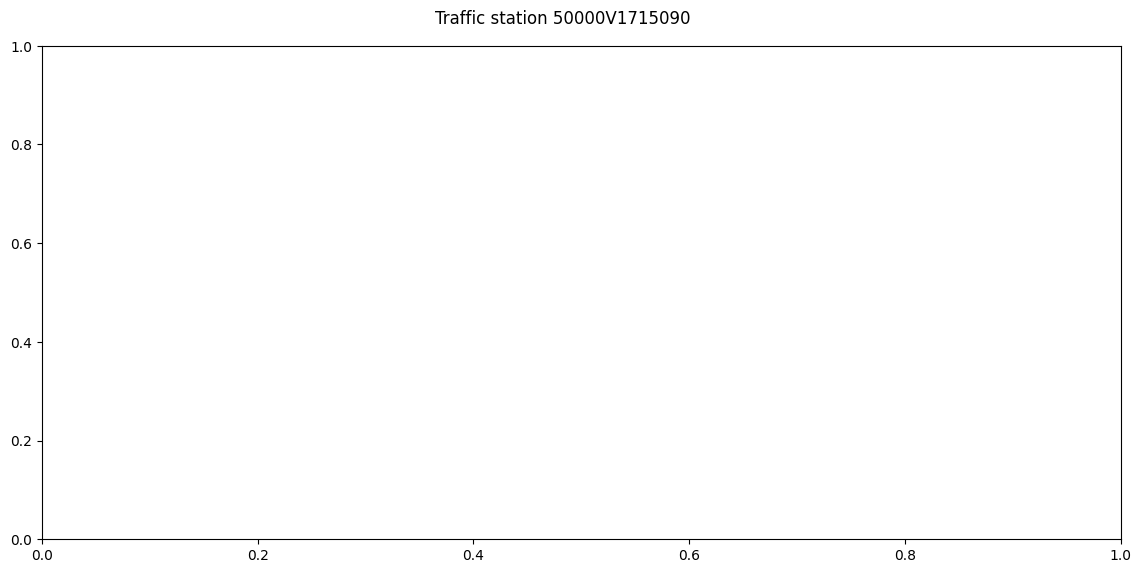

In [3]:
config = configs[0]
config["checkpoint_file"] = "checkpoints/NN.pth"
config["epochs"] = 5
config_baseline["val_per_epoch"] = 1
name = config["name"]
lr = config["lr"]
batch_size = config["batch_size"]
loss_function = nn.L1Loss()

device = 'cpu'
model = BaseLineModel()
train_dataloader = TrafficVolumeDataLoader(train_data_file, batch_size, num_workers, shuffle=True)
val_dataloader = TrafficVolumeDataLoader(val_data_file, batch_size, num_workers)
test_dataloader = TrafficVolumeDataLoader(test_data_file, batch_size, num_workers)
trainer = BaselineTrainer(model, train_dataloader, val_dataloader, test_dataloader, config, loss_function, device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
trainer.train(optimizer)

# Evaluate model on test data and compute test loss
trainer.evaluate()

# Make some prediction and save plot
from_index = 500 
length = 500
trainer.save_prediction_plot(from_index, length)

Using pre-defined graph from file (data\graph.pkl)...
Creating edge index and edge features...
Loaded datafile data\time_series_train.pkl with 49088 rows...
Loaded datafile data\time_series_val.pkl with 10518 rows...
Loaded datafile data\time_series_test.pkl with 10518 rows...
Earlystopper active with limit: 20 steps and delta: 0.5.
Model size: 0.51 MB
Parameters: 113999
Loading checkpoint...
Evaluating model on test data...


100%|██████████| 83/83 [01:20<00:00,  1.03it/s] 


Test Loss (L1/MAE): 28.0953
Test Loss (L2/RMSE): 53.0013
Saving prediction plots to directory figs\gnn_predictions...


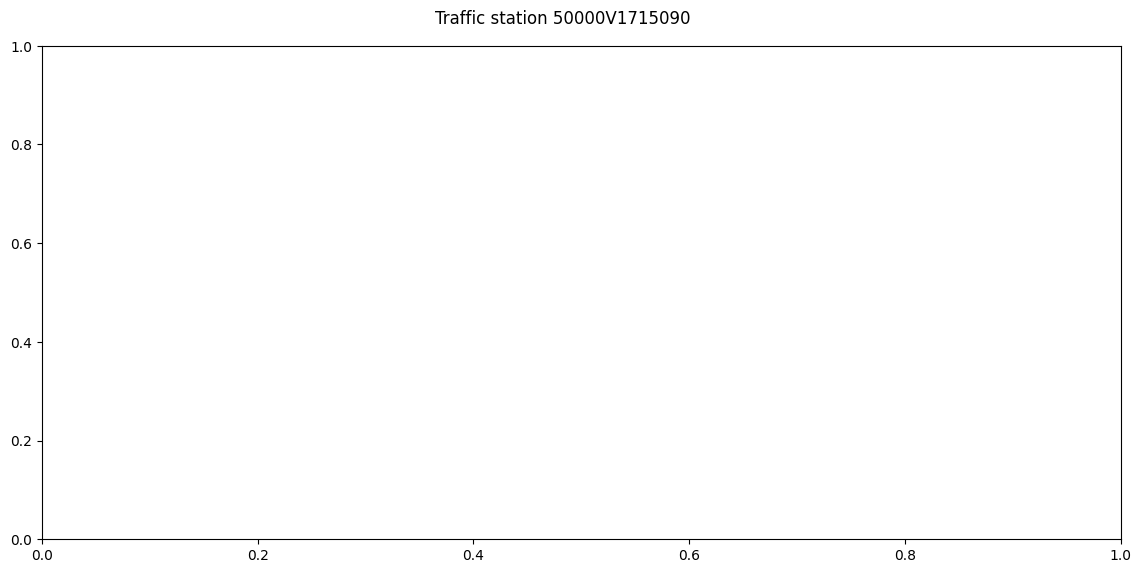

In [4]:
config = configs[1]
name = config["name"]
lr = config["lr"]
batch_size = config["batch_size"]
loss_function = nn.L1Loss()

device = 'cpu'
model = GNNModel()
edge_index, edge_weight = create_edge_index_and_features(stations_included_file, stations_data_file, graph_file)
train_dataloader = TrafficVolumeGraphDataLoader(train_data_file, edge_index, edge_weight, batch_size, num_workers, shuffle=True)
val_dataloader = TrafficVolumeGraphDataLoader(val_data_file, edge_index, edge_weight, batch_size, num_workers)
test_dataloader = TrafficVolumeGraphDataLoader(test_data_file, edge_index, edge_weight, batch_size, num_workers)
trainer = GNNTrainer(model, train_dataloader, val_dataloader, test_dataloader, config, loss_function, device)
    
trainer.print_model_size()

# Evaluate model on test data and compute test loss
trainer.evaluate()

# Make some prediction and save plot
from_index = 500 
length = 500
trainer.save_prediction_plot(from_index, length)